# REVEAL
### Your Real Estate Visualization and Exploration tool for Analytical Learning


Used libraries :

In [1]:
import pandas as pd
import plotly.express as px
from plotly import graph_objects as go
import calendar
import math

For the visual of the notebook :

In [2]:
import plotly.io as pio
pio.templates.default='plotly_dark'

## 1 - Loading
Load the data file directly with the usefull columns.

In [3]:
paths = {
    "2019" : "valeursfoncieres-2019.txt",
    "2020" : "valeursfoncieres-2020.txt",
    "2021" : "valeursfoncieres-2021.txt",
    "2022" : "valeursfoncieres-2022.txt",
}

root_path = "assets/"

used_colomns = [ "Date mutation", "Valeur fonciere", "No voie", "Type de voie", "Voie", "Code postal", \
        "Type local", "Surface reelle bati", "Nombre pieces principales", "Surface terrain", "Commune", "Code departement" ]

data = pd.read_csv(root_path + paths["2020"], sep='|', usecols=used_colomns, dtype={ "Code departement" : str })

data.head()

Date mutation Valeur fonciere  No voie Type de voie           Voie  \
0    03/01/2022        55000,00     13.0          RUE  DE LA LIBERTE   
1    03/01/2022       143000,00      NaN          NaN   CHAMP COCHET   
2    03/01/2022       143000,00      NaN          NaN   CHAMP COCHET   
3    03/01/2022       143000,00     98.0          RTE   DE LA DOMBES   
4    04/01/2022          300,00      NaN          NaN    AUX PIERRES   

   Code postal            Commune Code departement   Type local  \
0       1000.0    BOURG-EN-BRESSE               01  Appartement   
1       1480.0          SAVIGNEUX               01          NaN   
2       1480.0          SAVIGNEUX               01          NaN   
3       1480.0          SAVIGNEUX               01  Appartement   
4       1480.0  MESSIMY SUR SAONE               01          NaN   

   Surface reelle bati  Nombre pieces principales  Surface terrain  
0                 24.0                        1.0              NaN  
1                  NaN                        NaN             84.0  
2                  NaN                        NaN             88.0  
3                140.0                        3.0              NaN  
4                  NaN                        NaN            510.0

Load France population for deeper analysis.

In [4]:
data_population = pd.read_csv(root_path + "population-dep.csv", sep=';', usecols=['Code Département', 'Population'])
data_population.rename(columns={ "Code Département" : "Code departement" }, inplace=True)
data_population.sort_values(by="Code departement", inplace=True)
data_population.head()

Code departement  Population
27               01      649654
38               02      534286
51               03      338978
21               04      161664
8                05      141576

## 2 - Cleaning

Real estate value of 0€, surface of 0m^2, room count of 0, are non-sense.

In [5]:
data.dropna(subset=["Valeur fonciere", "Surface reelle bati", "Nombre pieces principales"], inplace=True)

data["Date mutation"] = pd.to_datetime(data["Date mutation"], format='%d/%m/%Y')

data["Valeur fonciere"] = data["Valeur fonciere"].str.replace(',', '.').astype(float)
data["Nombre pieces principales"] = data["Nombre pieces principales"].astype(int)

data.drop(data[data["Surface reelle bati"] == 0].index, inplace=True)
data.drop(data[data["Nombre pieces principales"] == 0].index, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1388730 entries, 0 to 4617588
Data columns (total 12 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Date mutation              1388730 non-null  datetime64[ns]
 1   Valeur fonciere            1388730 non-null  float64       
 2   No voie                    1379529 non-null  float64       
 3   Type de voie               1235716 non-null  object        
 4   Voie                       1388690 non-null  object        
 5   Code postal                1388695 non-null  float64       
 6   Commune                    1388730 non-null  object        
 7   Code departement           1388730 non-null  object        
 8   Type local                 1388730 non-null  object        
 9   Surface reelle bati        1388730 non-null  float64       
 10  Nombre pieces principales  1388730 non-null  int64         
 11  Surface terrain            866011 non-null

## 3 - Filtering

In [6]:
price_min = 0
price_max = 1000000

data = data[data["Valeur fonciere"].between(left=price_min, right=price_max)]

## 4 - Interpreting and visualizing

**Mean square meter price**

In [7]:
data.insert(1, "Prix/m2", [ p / s for p, s in zip(data["Valeur fonciere"], data["Surface reelle bati"]) ])
data.head()

Date mutation      Prix/m2  Valeur fonciere  No voie Type de voie  \
0     2022-01-03  2291.666667          55000.0     13.0          RUE   
3     2022-01-03  1021.428571         143000.0     98.0          RTE   
5     2022-01-06  2361.111111         255000.0    282.0          RTE   
8     2022-01-03  4166.666667         525000.0    217.0           PL   
12    2022-01-05   547.008547          64000.0     12.0           BD   

                   Voie  Code postal               Commune Code departement  \
0         DE LA LIBERTE       1000.0       BOURG-EN-BRESSE               01   
3          DE LA DOMBES       1480.0             SAVIGNEUX               01   
5           DE POISATON       1560.0      MANTENAY-MONTLIN               01   
8   DE LA CROIX BLANCHE       1390.0  SAINT-ANDRE-DE-CORCY               01   
12              DE BROU       1000.0       BOURG-EN-BRESSE               01   

     Type local  Surface reelle bati  Nombre pieces principales  \
0   Appartement                 24.0                          1   
3   Appartement                140.0                          3   
5        Maison                108.0                          5   
8   Appartement                126.0                          4   
12  Appartement                117.0                          2   

    Surface terrain  
0               NaN  
3               NaN  
5             649.0  
8             628.0  
12              NaN

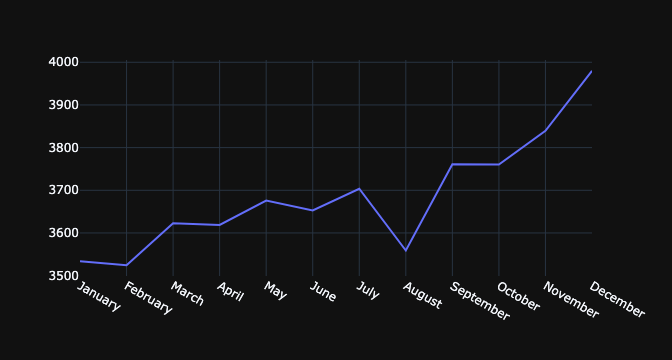

In [8]:
s = data.groupby(data["Date mutation"].dt.month)["Prix/m2"].mean()

fig = px.line(x=list(calendar.month_name)[1:], y=list(s.values), labels={'x':'', 'y':''})
fig.show()

**Sales count**

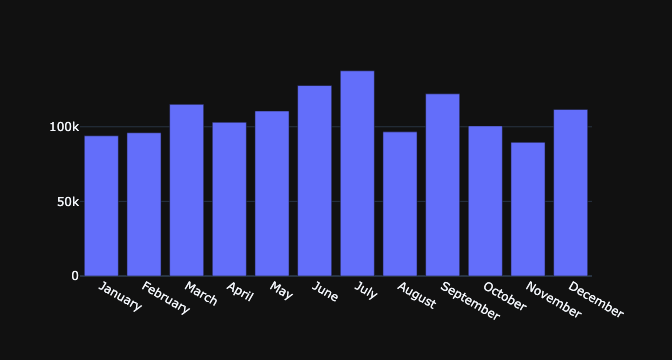

In [25]:
s = data.groupby(data["Date mutation"].dt.month)["Valeur fonciere"].count()

fig = px.bar(x=list(calendar.month_name)[1:], y=s.values, labels={'x':'', 'y':''})
fig.show()

**Real estate value by total surface**

/Users/stanleyarn/miniconda3/envs/django/lib/python3.9/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



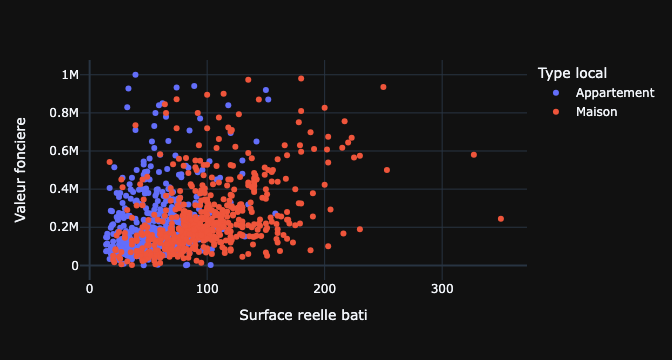

In [24]:
fig = px.scatter(data.sample(1000), x="Surface reelle bati", y="Valeur fonciere", color="Type local")
fig.show()

**Sold surface**

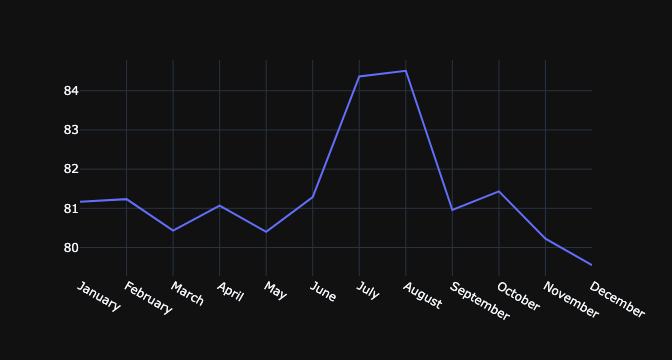

In [10]:
s = data.groupby(data["Date mutation"].dt.month)["Surface reelle bati"].mean()
meanprice = list(s.values)

fig = px.line(x=list(calendar.month_name)[1:], y=meanprice, labels={'x':'', 'y':''})
fig.show()

**Mean real estate value per department**

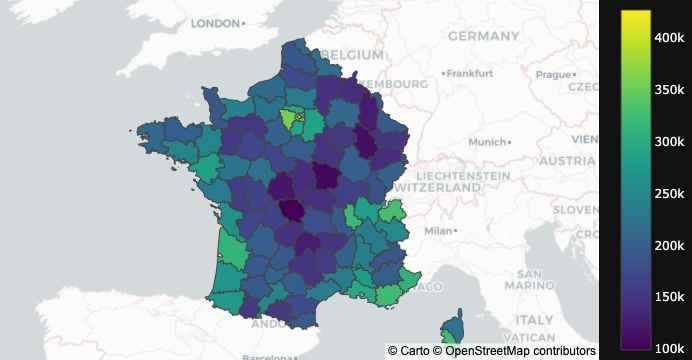

In [11]:
s = data.groupby("Code departement")["Valeur fonciere"].mean()
dep, meanprice = list(s.index), list(s.values)

geojson="https://france-geojson.gregoiredavid.fr/repo/departements.geojson"

fig = go.Figure(go.Choroplethmapbox(geojson=geojson, featureidkey = "properties.code", \
        locations=dep, z=meanprice, zauto = True, colorscale = 'viridis', showscale = True))
fig.update_layout(mapbox_style="carto-positron", mapbox_zoom=4, mapbox_center = {"lat": 47, "lon": 2.3522}, \
        margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

**Mean square meter price per department**

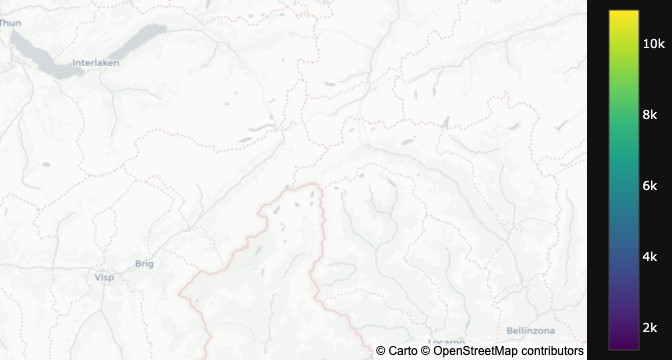

In [12]:
s = data.groupby("Code departement")["Prix/m2"].mean()
dep, meanpricem2 = list(s.index), list(s.values)

fig = go.Figure(go.Choroplethmapbox(geojson=geojson, featureidkey = "properties.code", \
        locations=dep, z=meanpricem2, zauto = True, colorscale = 'viridis', showscale = True))
fig.update_layout(mapbox_style="carto-positron", mapbox_zoom=4, mapbox_center = {"lat": 47, "lon": 2.3522}, \
        margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

**Sale value by typologies** (limited to 6 rooms)

/Users/stanleyarn/miniconda3/envs/django/lib/python3.9/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



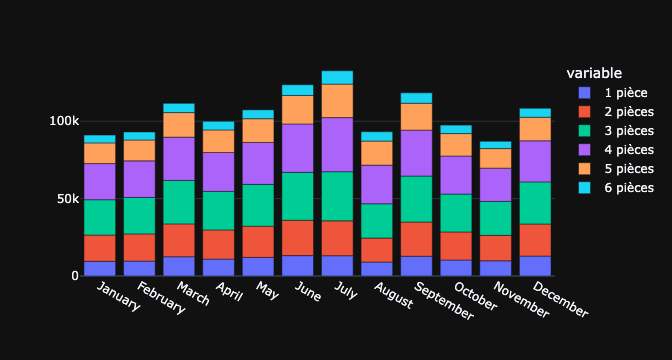

In [13]:
s = data.groupby([data["Nombre pieces principales"], data["Date mutation"].dt.month])["Nombre pieces principales"].count()

df = pd.DataFrame({str(i) + (" pièce" if i == 1 else " pièces") : s[i].tolist() for i in range(1, 7)})
df.insert(0, "Date mutation", list(calendar.month_name)[1:])

fig = px.bar(df, x="Date mutation", y=[str(i) + (" pièce" if i == 1 else " pièces") for i in range(1, 7)], labels={'value':'', 'Date mutation':''})
fig.show()

**Mean square meter price by typologies** (limited to 6 rooms)

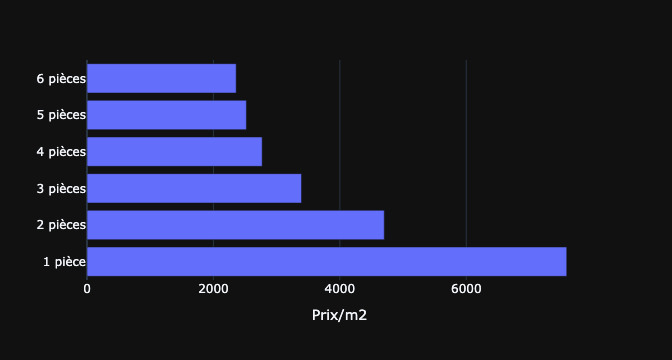

In [14]:
s = data.groupby("Nombre pieces principales")["Prix/m2"].mean()
s = s.head(6)

fig = px.bar(y=[str(x) + (" pièce" if x == 1 else " pièces") for x in s.index], x=s.values, orientation='h', labels={'y':'', 'x':'Prix/m2'})
fig.show()

**Typologie moyenne par département**

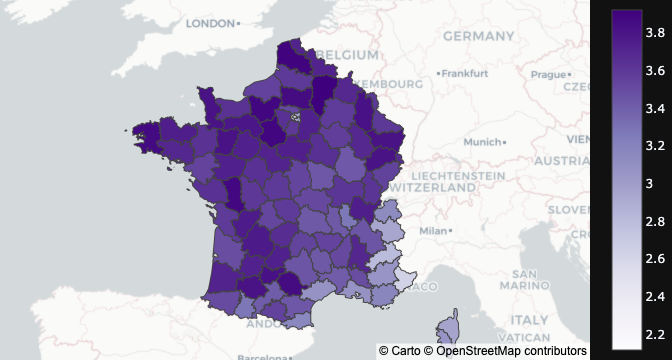

In [29]:
s = data.groupby("Code departement")["Nombre pieces principales"].mean()
dep, meantypo = s.index, s.values

fig = go.Figure(go.Choroplethmapbox(geojson=geojson, featureidkey = "properties.code", \
            locations=dep, z=meantypo, zauto = True, colorscale = 'purples', showscale = True))
fig.update_geos(scope="europe")
fig.update_layout(mapbox_style="carto-positron", mapbox_zoom=4, mapbox_center = {"lat": 47, "lon": 2.3522}, \
    margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

**Mean square meter price by building types**

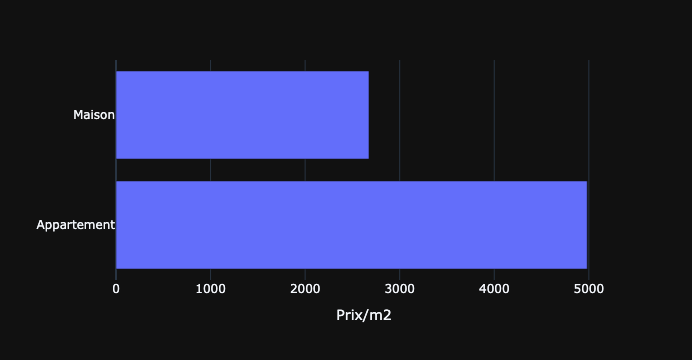

In [15]:
s = data.groupby("Type local")["Prix/m2"].mean()

fig = px.bar(y=s.index, x=s.values, orientation='h', labels={'y':'', 'x':'Prix/m2'})
fig.show()

**Share of typologies**

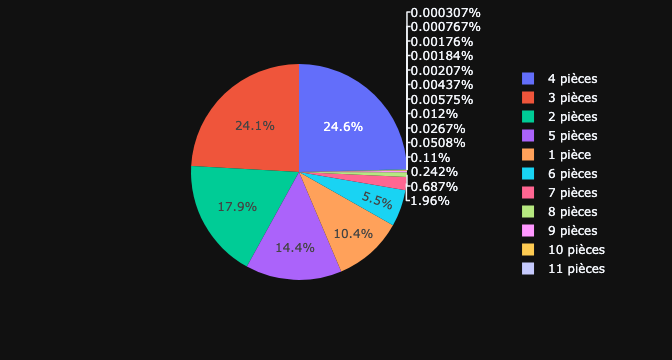

In [16]:
s = data.groupby("Nombre pieces principales")["Nombre pieces principales"].count()
s = s.head(20)

fig = px.pie(names=[str(x) + (" pièce" if x == 1 else " pièces") for x in s.index], values=list(s.values))
fig.show()

**Share of buildings types**

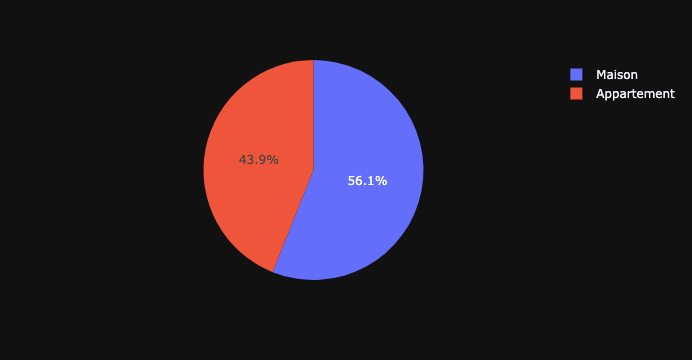

In [17]:
s = data.groupby("Type local")["Type local"].count()

fig = px.pie(names=s.index, values=s.values)
fig.show()

**Real estate value by department population**

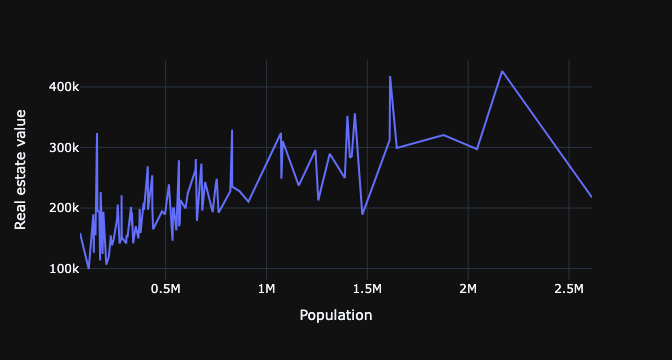

In [18]:
dataj = data.merge(data_population, on="Code departement", how="left")

s = dataj.groupby("Population")["Valeur fonciere"].mean()

fig = px.line(x=s.index, y=s.values, labels={'x':'Population', 'y':'Real estate value'})
fig.show()


**Real estate value by totale surface and population**

/Users/stanleyarn/miniconda3/envs/django/lib/python3.9/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



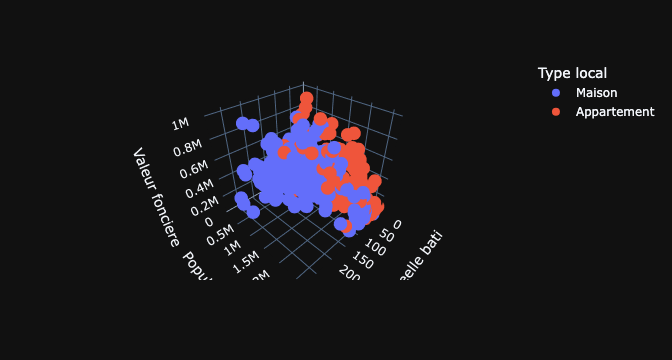

In [27]:
fig  = px.scatter_3d(dataj.sample(1000), x="Surface reelle bati", y="Population", z="Valeur fonciere", color = "Type local")
fig.show()

**Sale count by department population**

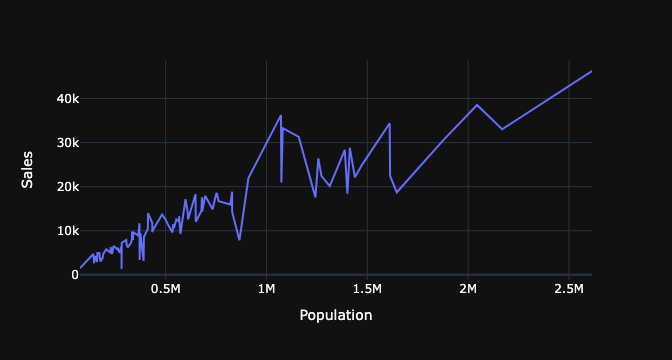

In [19]:
s = dataj.groupby("Population")["Population"].count()

fig = px.line(x=s.index, y=s.values, labels={'x':'Population', 'y':'Sales'})
fig.show()

**Mean sold surface by department population**

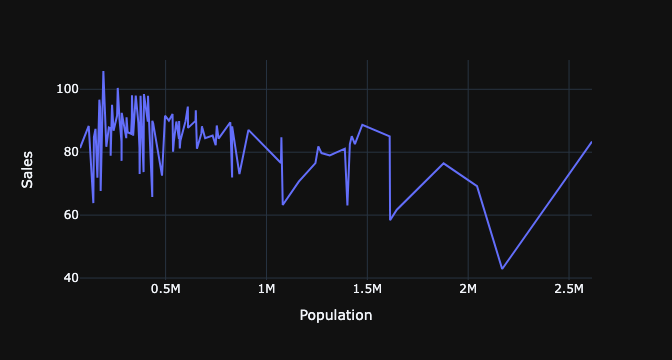

In [20]:
s = dataj.groupby("Population")["Surface reelle bati"].mean()

fig = px.line(x=s.index, y=s.values, labels={'x':'Population', 'y':'Sales'})
fig.show()

**Square meter price by department population**

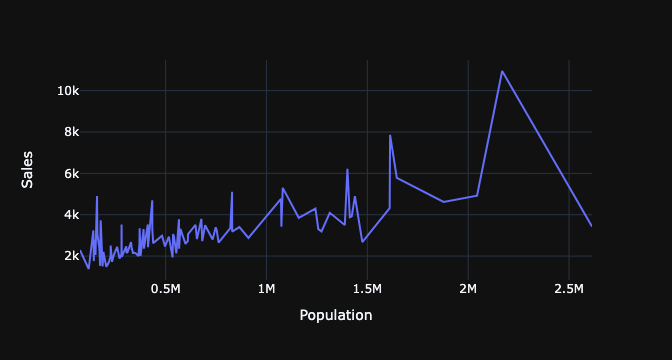

In [21]:
s = dataj.groupby("Population")["Prix/m2"].mean()

fig = px.line(x=s.index, y=s.values, labels={'x':'Population', 'y':'Sales'})
fig.show()

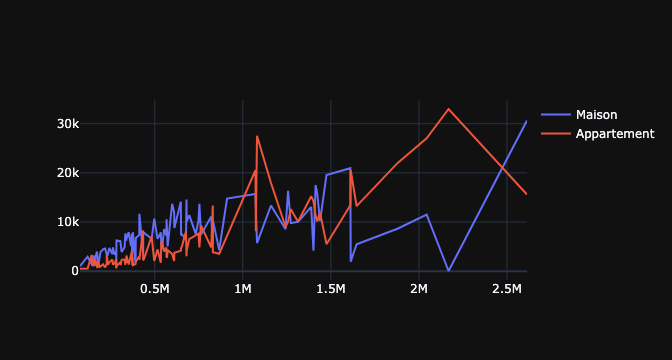

In [22]:
s = dataj.groupby(["Type local", "Population"])["Type local"].count()

fig = go.Figure()
fig.add_trace(go.Scatter(x=s["Maison"].index, y=s["Maison"].values, mode='lines', name='Maison'))
fig.add_trace(go.Scatter(x=s["Maison"].index, y=s["Appartement"].values, mode='lines', name='Appartement'))
fig.show()

## Covid-19 analysis
See the website.